
Attribute-wise Performance:
Attribute                      Accuracy Precision Recall   F1      
5_o_Clock_Shadow               0.9469  0.8598  0.6236  0.7229
Arched_Eyebrows                0.8590  0.8110  0.6153  0.6997
Attractive                     0.8368  0.8182  0.8762  0.8462
Bags_Under_Eyes                0.8636  0.7448  0.5069  0.6032
Bald                           0.9918  0.8305  0.7972  0.8135
Bangs                          0.9661  0.8836  0.8944  0.8890
Big_Lips                       0.7949  0.6976  0.2614  0.3803
Big_Nose                       0.8596  0.8041  0.5304  0.6392
Black_Hair                     0.9201  0.8466  0.8137  0.8298
Blond_Hair                     0.9634  0.8901  0.8588  0.8742
Blurry                         0.9688  0.7745  0.5468  0.6411
Brown_Hair                     0.8858  0.7313  0.7009  0.7158
Bushy_Eyebrows                 0.9305  0.8116  0.6657  0.7315
Chubby                         0.9631  0.7484  0.5403  0.6276
Double_Chin                    0.96

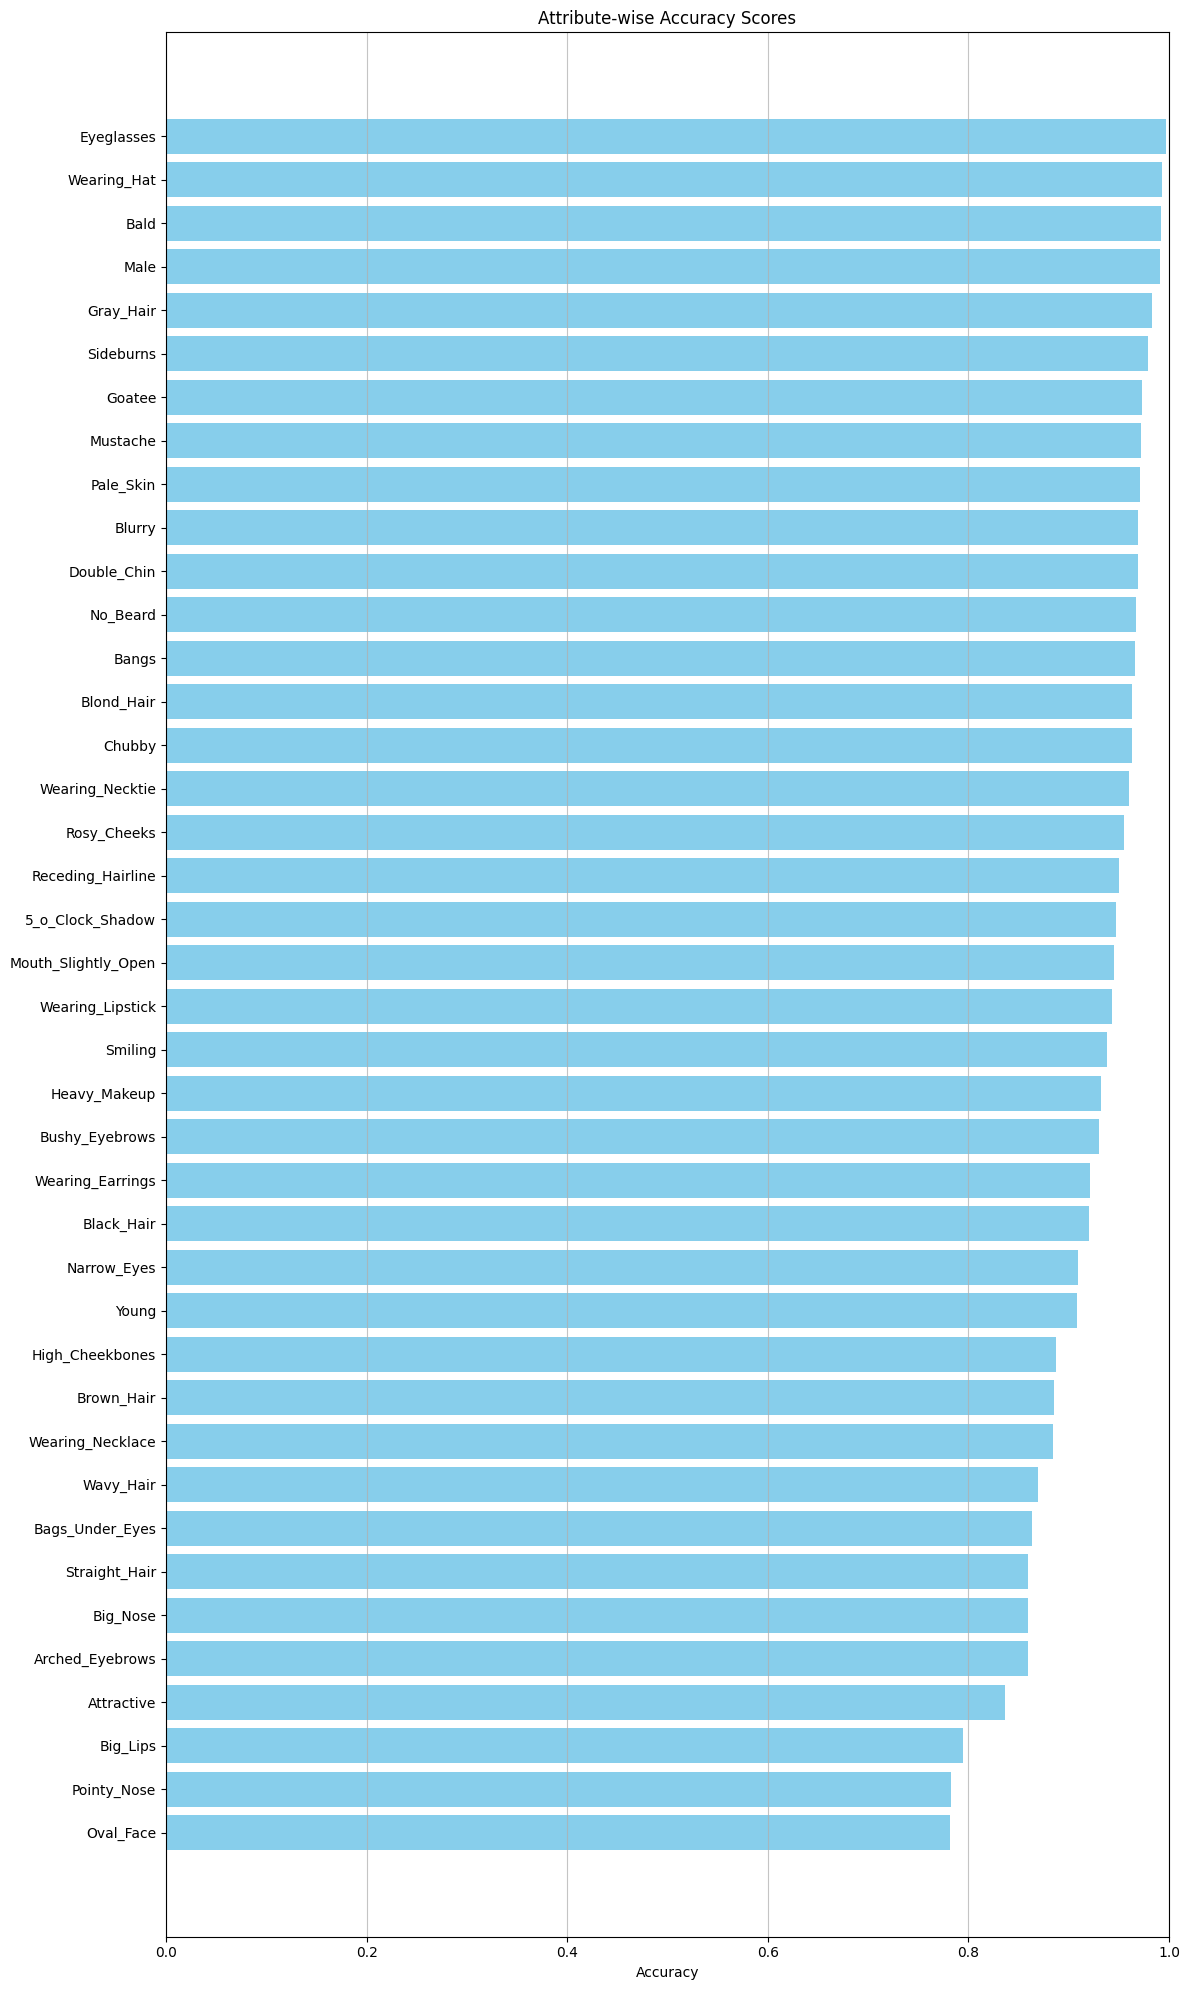

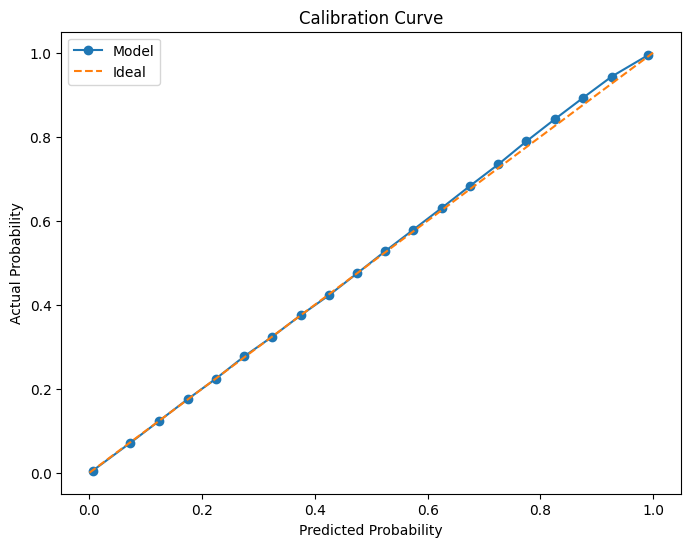

In [8]:
# celeb_a_test.py
!pip install torch torchvision pandas matplotlib seaborn scikit-learn

# celeb_a_test.py
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader  # Added Dataset import
from PIL import Image
import pandas as pd
from torchvision import transforms, models
from typing import Dict
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
import torch.nn as nn  # Added nn import

# Configuration
class Config:
    root_dir = 'C:/celeba/img_align_celeba/img_align_celeba'
    csv_path = 'C:/celeba/list_attr_celeba.csv'
    num_classes = 40
    batch_size = 64
    image_size = 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    attribute_names = [
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
        'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
        'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
        'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
        'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
        'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
        'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
        'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
    ]

# Dataset
class CelebADataset(Dataset):
    def __init__(self, root_dir, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.df.iloc[:, 1:] = self.df.iloc[:, 1:].replace(-1, 0)
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(Config.mean, Config.std)
        ])
        self.image_names = self.df['image_id']
        self.labels = self.df.drop('image_id', axis=1).values.astype('float32')

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        image = Image.open(img_path).convert('RGB')
        return self.transform(image), self.labels[idx]

# Model loading
def load_model(device):
    model = models.resnet50(weights=None)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, Config.num_classes)
    )
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    return model.to(device)

# Metrics calculation
def calculate_metrics(outputs, labels):
    preds = (torch.sigmoid(outputs) > 0.5).float()
    probs = torch.sigmoid(outputs)
    
    tp = (preds * labels).sum(0).cpu().numpy()
    fp = (preds * (1 - labels)).sum(0).cpu().numpy()
    fn = ((1 - preds) * labels).sum(0).cpu().numpy()
    tn = ((1 - preds) * (1 - labels)).sum(0).cpu().numpy()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'probs': probs.cpu().numpy(),
        'labels': labels.cpu().numpy(),
        'preds': preds.cpu().numpy()
    }

# Visualization functions
def plot_accuracy_barchart(metrics):
    plt.figure(figsize=(12, 20))
    acc_df = pd.DataFrame({
        'Attribute': Config.attribute_names,
        'Accuracy': metrics['accuracy']
    }).sort_values('Accuracy')
    
    plt.barh(acc_df['Attribute'], acc_df['Accuracy'], color='skyblue')
    plt.title('Attribute-wise Accuracy Scores')
    plt.xlabel('Accuracy')
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.75)
    plt.tight_layout()
    plt.show()

def plot_calibration(metrics):
    plt.figure(figsize=(8, 6))
    prob_true, prob_pred = calibration_curve(
        metrics['labels'].flatten(),
        metrics['probs'].flatten(),
        n_bins=20
    )
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

# Main test function
def test_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(device)
    model.eval()
    
    dataset = CelebADataset(Config.root_dir, Config.csv_path)
    loader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=False)
    
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    outputs = torch.cat(all_outputs)
    labels = torch.cat(all_labels)
    metrics = calculate_metrics(outputs, labels)
    
    # Print detailed metrics
    print("\nAttribute-wise Performance:")
    print(f"{'Attribute':<30} {'Accuracy':<8} {'Precision':<8} {'Recall':<8} {'F1':<8}")
    for idx, name in enumerate(Config.attribute_names):
        print(f"{name:<30} "
              f"{metrics['accuracy'][idx]:.4f}  "
              f"{metrics['precision'][idx]:.4f}  "
              f"{metrics['recall'][idx]:.4f}  "
              f"{metrics['f1'][idx]:.4f}")
    
    # Generate plots
    plot_accuracy_barchart(metrics)
    plot_calibration(metrics)
    
    # Save metrics
    pd.DataFrame({
        'Attribute': Config.attribute_names,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1': metrics['f1']
    }).to_csv('attribute_metrics.csv', index=False)

if __name__ == "__main__":
    test_model()